# Install modules

In [2]:
# !pip install simplejson
from types import SimpleNamespace
import os
import re
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

# Function to read .PSSESSION files

In [3]:
import json
import pandas as pd
import numpy as np

def extract_eis_data(file_path):
    # Read and parse JSON
    json_str = ""
    try:
        with open(file_path, 'r', encoding='utf-16') as f:
            content = f.read()
            brace_count = 0
            start = None
            for i, char in enumerate(content):
                if char == '{':
                    if brace_count == 0:
                        start = i
                    brace_count += 1
                elif char == '}':
                    brace_count -= 1
                    if brace_count == 0:
                        json_str = content[start:i+1]
                        break
            if not json_str:
                raise ValueError("No valid JSON object found in the file.")
        data = json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"JSON parsing error: {e}")
        raise
    except Exception as e:
        print(f"Error reading file: {e}")
        raise

    # Extract EIS data
    values = data["Measurements"][0]["DataSet"]["Values"]
    description_to_column = {
        "Frequency": "Frequency/Hz",
        "Z": "Z/Ohm",
        "ZRe": "ZRe/Ohm",
        "ZIm": "-ZIm/Ohm",
        "Phase": "-Phase/Degr",
        "Capacitance": "Cs/F"
    }
    eis_data = {}
    for value in values:
        desc = value["Description"]
        if desc in description_to_column:
            key = description_to_column[desc]
            eis_data[key] = [item["V"] for item in value["DataValues"]]

    # Create DataFrame
    df = pd.DataFrame(eis_data)

    # Calculate real and imaginary parts of capacitance
    f = df['Frequency/Hz'].values
    Z_re = df['ZRe/Ohm'].values
    Z_im = df['-ZIm/Ohm'].values  # -Z'', where Z = Z_re - j Z'' and Z'' = -Z_im
    omega = 2 * np.pi * f
    Z = Z_re + 1j * -1 * Z_im
    C = 1 / (1j * omega * Z)
    df['CRe/F'] = C.real
    df['-CIm/F'] = -C.imag

    return df

,Frequency/Hz,ZRe/Ohm,-ZIm/Ohm,Z/Ohm,-Phase/Degr,Cs/F,CRe/F,-CIm/F
0,100000.000000,474.615348,7.591548,474.676058,0.916377,2.096475e-07,5.362358e-11,3.352488e-09
1,79432.820312,475.889123,8.881369,475.971991,1.069169,2.256006e-07,7.854839e-11,4.208847e-09
2,63095.734375,476.393095,9.151789,476.480992,1.100550,2.756222e-07,1.016799e-10,5.292909e-09
3,50118.722656,477.754483,9.245408,477.843932,1.108638,3.434742e-07,1.285802e-10,6.644354e-09
4,39810.718750,477.845080,10.395337,477.958139,1.246251,3.845754e-07,1.819194e-10,8.362334e-09
5,31622.777344,478.793188,11.154601,478.923106,1.334597,4.511969e-07,2.447612e-10,1.050598e-08
6,25118.865234,479.353021,12.056537,479.504618,1.440782,5.255300e-07,3.322440e-10,1.320961e-08
7,19952.623047,480.532732,12.636519,480.698854,1.506354,6.312373e-07,4.362158e-10,1.658811e-08
8,15848.931641,481.306521,14.624345,481.528648,1.740379,6.866631e-07,6.333624e-10,2.084479e-08
9,12589.253906,482.228451,16.424197,482.508065,1.950680,7.697257e-07,8.918568e-10,2.618568e-08


<Axes: xlabel='CRe/F'>

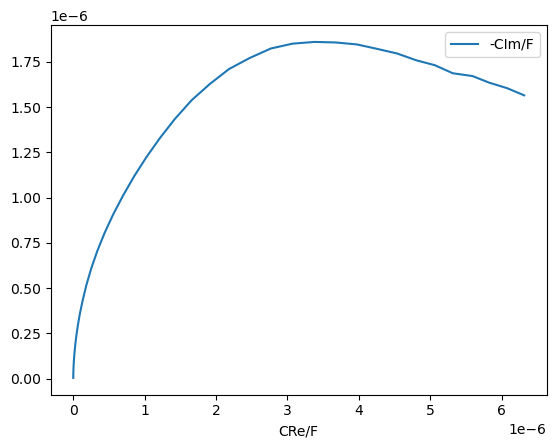

In [4]:
# Example usage:
df = extract_eis_data('FILE1.pssession')
display(df)
df.plot('CRe/F', '-CIm/F')

In [ ]:
df.columns

In [ ]:
df.index

# ML Regression - Predicting Pathogen concentration using EIS spectra.

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is 

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is 

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is 

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is 

Test Mean Squared Error (MSE): 6.5512


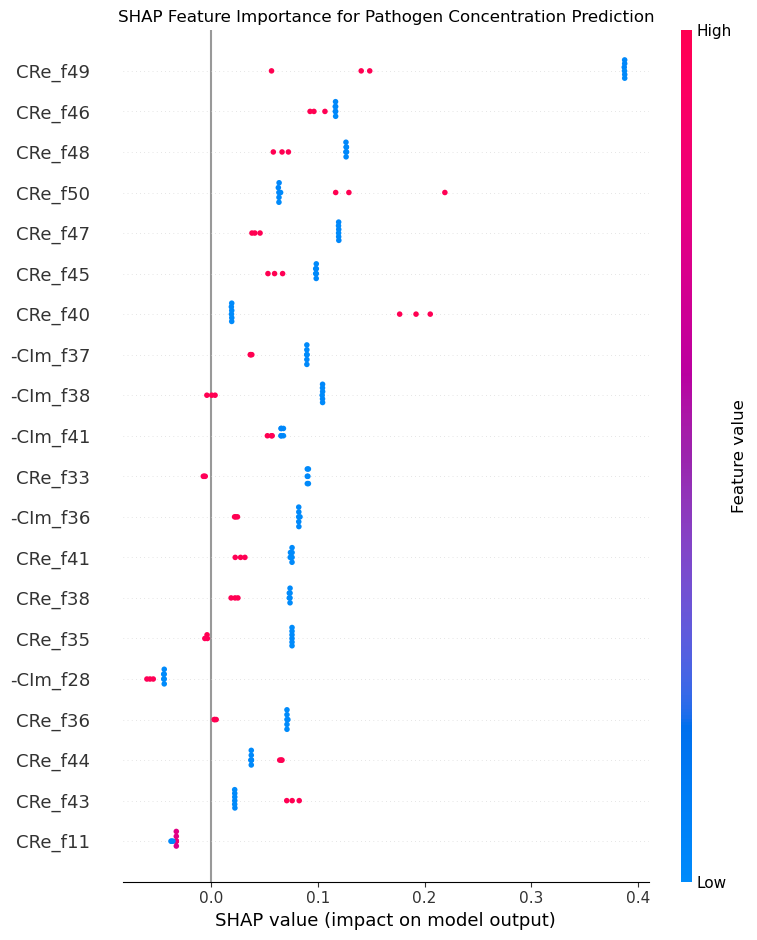

In [6]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt

# Directory containing the .PSSESSION files
directory = r'C:\Users\joshi\Desktop\My Folder\OneDrive - Washington University in St. Louis\PostDoc Projects\Biosensing_Projects\1_Biosensing_ML_Regression\20240815_H5N1\Day2 - H5N1 Detection\ALL_DATA'

# List all .PSSESSION files
files = [f for f in os.listdir(directory) if f.endswith('.pssession')]

# Function to extract concentration from filename
def get_concentration(filename):
    if 'Blank_PBS' in filename:
        return 0
    else:
        match = re.search(r'H5N1_10\^(\d+)x', filename)
        if match:
            exponent = int(match.group(1))
            return (2*10**(10) / 10**exponent) # H5N1 Concentration: 2*10**(10) / dilution factor
        else:
            raise ValueError(f"Cannot extract concentration from {filename}")

# Extract features and targets
features = []
targets = []
con_labels = []  # For stratification

for file in files:
    filepath = os.path.join(directory, file)
    df = extract_eis_data(filepath)
    cre = df['CRe/F'].values
    cim = df['-CIm/F'].values
    feature_vector = np.concatenate([cre, cim])
    features.append(feature_vector)
    concentration = get_concentration(file)
    if concentration == 0:
        target = 0  # Blank
        con_label = 'blank'
    else:
        target = np.log10(concentration)
        con_label = f'10^{int(np.log10(concentration))}'
    targets.append(target)
    con_labels.append(con_label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(targets)

# Split into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=9, stratify=con_labels, random_state=42
)


#######  REPLACE ONLY THIS BLOCK OF CODE FOR SYNTHETIC DATA GENERATION
### Synthetic data generation using GPR
# Separate non-blank and blank samples
non_zero_idx = y_train > 0
X_train_non_zero = X_train[non_zero_idx]
y_train_non_zero = y_train[non_zero_idx]
blank_idx = y_train == 0
X_train_blank = X_train[blank_idx]

# Fit GPR for each feature (CRe/F, -CIm/F) for non-blank samples
gprs = []
for i in range(102):  # 51 CRe + 51 -CIm
    kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer=5)
    gpr.fit(np.log10(y_train_non_zero).reshape(-1, 1), X_train_non_zero[:, i])
    gprs.append(gpr)

# Generate synthetic non-blank samples
n_synthetic_non_zero = 100
new_concs = np.logspace(np.log10(min(y_train_non_zero)), np.log10(max(y_train_non_zero)), n_synthetic_non_zero)
new_log_concs = np.log10(new_concs)
synthetic_X = np.zeros((n_synthetic_non_zero, 102))
for i in range(102):
    pred, std = gprs[i].predict(new_log_concs.reshape(-1, 1), return_std=True)
    synthetic_X[:, i] = pred + np.random.normal(0, std, n_synthetic_non_zero)

# Generate synthetic blanks
n_synthetic_blanks = 20
blank_mean = np.mean(X_train_blank, axis=0) if len(X_train_blank) > 0 else np.zeros(102)
blank_cov = np.cov(X_train_blank.T) if len(X_train_blank) > 1 else np.diag(np.std(X_train, axis=0)**2)
synthetic_blank_X = np.random.multivariate_normal(blank_mean, blank_cov, n_synthetic_blanks)

# Combine synthetic data
synthetic_X = np.vstack([synthetic_X, synthetic_blank_X])
synthetic_y = np.hstack([new_concs, np.zeros(n_synthetic_blanks)])

# Assign synthetic data to X_synth and y_synth
X_synth = synthetic_X
y_synth = synthetic_y
###
#######


# Combine with original training data
X_train_combined = np.vstack([X_train, X_synth])
y_train_combined = np.hstack([y_train, y_synth])

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on test set
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error (MSE): {mse:.4f}")

# SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Create feature names
feature_names = [f'CRe_f{i}' for i in range(51)] + [f'-CIm_f{i}' for i in range(51)]

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.title("SHAP Feature Importance for Pathogen Concentration Prediction")
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
y_test

In [ ]:
y_pred